Using the Hermite-Simpson Method: 
$$
\bar{y} = \frac{1}{2}(y_i+y_{i+1}) + \frac{h_i}{8}(f_i-f_{i+1}) \\
\bar{f} = f(\bar{y},t_i+\frac{h_i}{2}) \\
y_{i+1} = y_i +\frac{h_i}{6}(f_i+4\bar{f} + f_{i+1})
$$

Parmis les équations, la deuxième, où les deux paramètres d'équation dynamique sont pas donné directement, est le plus difficile à réalisé en considérant l'interpolation de l'état et du temps

In [1]:
using JuMP
using Ipopt
#using COPSBenchmark
import Plots

In [12]:
function rocket_model_hersim(nh)
    h_0 = 1.0   #hauteur init
    v_0 = 0.0   #vitesse init
    m_0 = 1.0   #masse init
    g_0 = 1.0   #grativité init
    T_c = 3.5
    h_c = 500.0
    v_c = 620.0
    m_c = 0.6

    c = 0.5*sqrt(g_0 * h_0)
    m_f = m_c * m_0
    D_c = 0.5 * v_c * (m_0 / g_0)
    T_max = T_c * m_0 * g_0

    model = Model()

    @variables(model, begin
        1.0 <= h[i=0:nh,j=0:1],          (start=1.0)
        0.0 <= v[i=0:nh,j=0:1],          (start=i/nh*(1.0 - i/nh))
        m_f <= m[i=0:nh,j=0:1] <= m_0,   (start=(m_f - m_0)*(i/nh) + m_0)
        0.0 <= T[i=0:nh,j=0:1] <= T_max, (start=T_max/2.0)
        0.0 <= step,               (start=1/nh)
    end)

    @expressions(model, begin
        D[i=0:nh,j=0:1],  D_c*v[i,j]^2*exp(-h_c*(h[i,j] - h_0))/h_0
        g[i=0:nh,j=0:1],  g_0 * (h_0 / h[i,j])^2
        dh[i=0:nh,j=0:1], v[i,j]
        dv[i=0:nh,j=0:1], (T[i,j] - D[i,j] - m[i,j]*g[i,j]) / m[i,j]
        dm[i=0:nh,j=0:1], -T[i,j]/c
    end)
    
    @objective(model, Max, h[nh,0] + 1e-6 * sum(T[i,0]^2 for i in 0:nh))
    #@objective(model, Max, h[nh,0])

    #Hermite-Simpson Method
    @constraints(model,begin
        def_ref_h[i=1:nh-1], h[i,1] == 0.5 * (h[i,0] + h[i+1,0]) + 0.125 * step * (dh[i,0] - dh[i+1,0])
        def_ref_v[i=1:nh-1], v[i,1] == 0.5 * (v[i,0] + v[i+1,0]) + 0.125 * step * (dv[i,0] - dv[i+1,0])
        def_ref_m[i=1:nh-1], m[i,1] == 0.5 * (m[i,0] + m[i+1,0]) + 0.125 * step * (dm[i,0] - dm[i+1,0])

        con_dh[i=1:nh], h[i,0] == h[i-1,0] + 1/6 * step * (dh[i-1,0] + dh[i,0] + 4 * dh[i-1,1])
        con_dv[i=1:nh], v[i,0] == v[i-1,0] + 1/6 * step * (dv[i-1,0] + dv[i,0] + 4 * dv[i-1,1])
        con_dm[i=1:nh], m[i,0] == m[i-1,0] + 1/6 * step * (dm[i-1,0] + dm[i,0] + 4 * dm[i-1,1])
    end)
    
    #Boundary constraints
    @constraints(model, begin
        h_ic, h[0,0] == h_0
        v_ic, v[0,0] == v_0
        m_ic, m[0,0] == m_0
        m_fc, m[nh,0] == m_f

        h_ic_1, h[0,1] == h_0
        v_ic_1, v[0,1] == v_0
        m_ic_1, m[0,1] == m_0
    end)

    return model
end

function Generate_thrust_hersim(nhs=nhs)
    P = Plots.plot(xlabel="Temps", ylabel="Value")
    Thrusts = [[[] for i in range(1,length(nhs))] for j in range(1,2)]
    for i in range(1,length(nhs))
        nh = nhs[i]
        model = rocket_model_hersim(nh)
        JuMP.set_optimizer(model, Ipopt.Optimizer)
        JuMP.optimize!(model)
        T_value = value.(model[:T]);
        T_Array = Array(T_value[:,0]);
        T_Array_dua = Array(T_value[:,1]);
        Thrusts[1][i] = T_Array
        Thrusts[2][i] = T_Array_dua
        Plots.plot!(LinRange(0,0.2,length(T_Array)),T_Array,label="T values for nh = $nh")
    end
    Plots.display(P)
    return Thrusts
end

Generate_thrust_hersim (generic function with 2 methods)

In [13]:
function rocket_model(nh)
    h_0 = 1.0   #hauteur init
    v_0 = 0.0   #vitesse init
    m_0 = 1.0   #masse init
    g_0 = 1.0   #grativité init
    T_c = 3.5
    h_c = 500.0
    v_c = 620.0
    m_c = 0.6

    c = 0.5*sqrt(g_0 * h_0)
    m_f = m_c * m_0
    D_c = 0.5 * v_c * (m_0 / g_0)
    T_max = T_c * m_0 * g_0

    model = Model()

    @variables(model, begin
        1.0 <= h[i=0:nh],          (start=1.0)
        0.0 <= v[i=0:nh],          (start=i/nh*(1.0 - i/nh))
        m_f <= m[i=0:nh] <= m_0,   (start=(m_f - m_0)*(i/nh) + m_0)
        0.0 <= T[i=0:nh] <= T_max, (start=T_max/2.0)
        0.0 <= step,               (start=1/nh)
    end)

    @expressions(model, begin
        D[i=0:nh],  D_c*v[i]^2*exp(-h_c*(h[i] - h_0))/h_0
        g[i=0:nh],  g_0 * (h_0 / h[i])^2
        dh[i=0:nh], v[i]
        dv[i=0:nh], (T[i] - D[i] - m[i]*g[i]) / m[i]
        dm[i=0:nh], -T[i]/c
    end)

    #@objective(model, Max, h[nh])
    @objective(model, Max, h[nh] + 1e-6 * sum(T[i]^2 for i in 0:nh))
    
    # Dynamics
    @constraints(model, begin
        con_dh[i=1:nh], h[i] == h[i-1] + 0.5 * step * (dh[i] + dh[i-1])
        con_dv[i=1:nh], v[i] == v[i-1] + 0.5 * step * (dv[i] + dv[i-1])
        con_dm[i=1:nh], m[i] == m[i-1] + 0.5 * step * (dm[i] + dm[i-1])
    end)
    # Boundary constraints
    @constraints(model, begin
        h_ic, h[0] == h_0
        v_ic, v[0] == v_0
        m_ic, m[0] == m_0
        m_fc, m[nh] == m_f
    end)

    return model
end

function Generate_thrust(nhs=nhs)
    Thrusts = [[] for i in range(1,length(nhs))]
    P = Plots.plot(xlabel="Temps", ylabel="Value")
    for i in range(1,length(nhs))
        nh = nhs[i]
        model = rocket_model(nh)
        JuMP.set_optimizer(model, Ipopt.Optimizer)
        JuMP.optimize!(model)
        T_value = value.(model[:T]);
        T_Array = Array(T_value);
        Thrusts[i] = T_Array
        Plots.plot!(LinRange(0,0.2,length(T_Array)),T_Array,label="T values for nh = $nh")
    end
    Plots.display(P)
    return Thrusts
end

Generate_thrust (generic function with 2 methods)

In [9]:
function Compa_nh_tol(nh,tol)
    p = Plots.plot(title = "Comparaison des courbes, nh = $nh, tol = $tol",xlabel="Temps", ylabel="Value")
    model1 = rocket_model(nh)
    model2 = rocket_model_hersim(nh)
    JuMP.set_optimizer(model1, Ipopt.Optimizer)
    JuMP.set_optimizer(model2, Ipopt.Optimizer)
    JuMP.set_attribute(model1, "tol", tol)
    JuMP.set_attribute(model2, "tol", tol)
    JuMP.optimize!(model1)
    JuMP.optimize!(model2)
    Thrust1 = collect(JuMP.value.(model1[:T]))[:, 1]
    Thrust2 = collect(JuMP.value.(model2[:T]))[:, 1]
    Plots.plot!(LinRange(0,1,length(Thrust1)),Thrust1,label="T values from Trapezoidal")
    Plots.plot!(LinRange(0,1,length(Thrust2)),Thrust2,label="T values from Hermite-Simpson")
    Plots.display(p)
    return p
end

Compa_nh_tol (generic function with 1 method)

In [ ]:
nhs = [100,500,1000,5000]
tols = [1e-6,1e-8,1e-10]
for nh in nhs
    for tol in tols
        p = Compa_nh_tol(nh,tol)
        # Plots.savefig("Photo/nh=$nh,tol=$tol.png")
    end
end

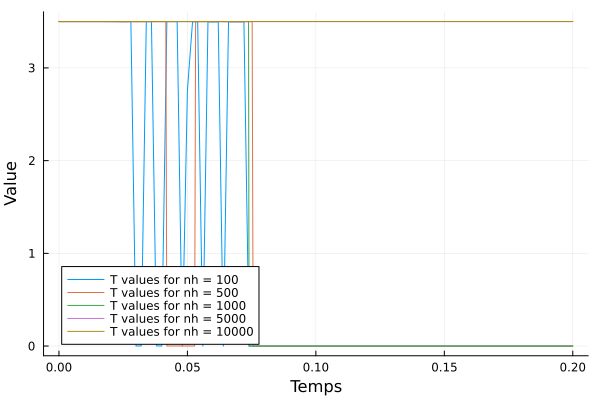


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.3.

Number of nonzeros in equality constraint Jacobian...:     2104
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     5001

Total number of variables............................:      405
                     variables with only lower bounds:      203
                variables with lower and upper bounds:      202
                     variables with only upper bounds:        0
Total number of equality constraints.................:      304
Total number of inequality c

5-element Vector{Vector{Any}}:
 [3.499947127460568, 3.4999695731227645, 3.499962973686316, 3.4999541409957833, 3.499941980650328, 3.499924651751933, 3.49989887781312, 3.499858416648154, 3.499790363407001, 3.49966543180933  …  2.012131813971926e-5, 2.0595273253547497e-5, 2.1227525143054708e-5, 2.207841202465262e-5, 2.324953221623864e-5, 2.492839116869962e-5, 2.7511686690743643e-5, 3.205402390109091e-5, 4.319247171584597e-5, 0.00011040482580955311]
 [3.4998079779369786, 3.4998674280630997, 3.4998636108018917, 3.499859652492871, 3.499855540226477, 3.4998512648077473, 3.4998468174179465, 3.4998421890305997, 3.4998373702165186, 3.4998323510457943  …  0.00019687491149869405, 0.0002064300535126668, 0.00021803295746016581, 0.0002325106069083235, 0.0002512493608996421, 0.00027680172811430634, 0.00031456577694146006, 0.0003789272420855912, 0.0005338902625973271, 0.001419479442406974]
 [3.49989781295066, 3.4999154679675226, 3.4999147040883654, 3.4999139356645306, 3.4999131605048794, 3.49991237793

In [6]:
Generate_thrust([100,500,1000,5000,10000])

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.3.

Number of nonzeros in equality constraint Jacobian...:     2104
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     4900

Total number of variables............................:      405
                     variables with only lower bounds:      203
                variables with lower and upper bounds:      202
                     variables with only upper bounds:        0
Total number of equality constraints.................:      304
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.0100000e+00 3.50e-02 1.63e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

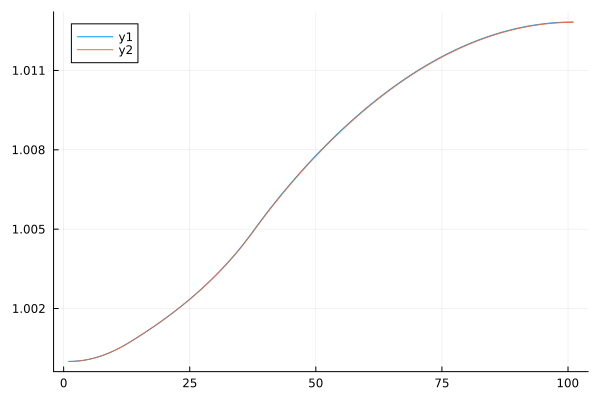

In [22]:
model1 = rocket_model(100)
JuMP.set_optimizer(model1,Ipopt.Optimizer)
JuMP.optimize!(model1)

model2 = rocket_model_hersim(100)
JuMP.set_optimizer(model2,Ipopt.Optimizer)
JuMP.optimize!(model2)

haut1 = collect(JuMP.value.(model1[:h]))
haut2 = collect(JuMP.value.(model2[:h]))[:,1]

Plots.plot(haut1)
Plots.plot!(haut2)
